# HW 6
In this assignment we'll tackle a slightly more complicated image classification problem than MNIST digit classification. We're going to classify characters that contain (gasp!) letters!

The dataset we'll play with is from University of California, Irvine (UCI) and contains a bunch of images of letters of various fonts. Some printed + scanned, some the values screen-capped from a computer. The images are 20x20 pixels, grayscale.

In [124]:
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import re

## step 1: data acquisition and cleanup



In [125]:
#make function returns two numpy arrays
def load_and_transform_CSV(file_path):
    #load data
    df = pd.read_csv(file_path)
    # look for column
    pixel_columns = [col for col in df.columns if col.startswith('r')]
    m_label_column = 'm_label'

    df_pixels = df[pixel_columns]
    df_labels = df[m_label_column]
    #nnormalize data
    Xs = df_pixels.values / 256.0

    Xs = Xs.reshape(-1,20,20)

    Ys = df_labels.values
    return Xs, Ys

def create_label_mapping(Ys):
    unique_labels = sorted(set(Ys))
    label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
    index_to_label = {idx: label for idx, label in enumerate(unique_labels)}

    Ys_mapped = np.array([label_to_index[label]for label in Ys])
    return Ys_mapped, label_to_index, index_to_label

file_path = "CFI/JOKERMAN.csv"
Xs, Ys = load_and_transform_CSV(file_path)
Ys_mapped, label_to_index, index_to_label = create_label_mapping(Ys)

print(f"Xs shape: {Xs.shape}")
print(f"Ys shape: {Ys.shape}")
print(f"label to index mapping: {label_to_index}")
print(f"index to label mapping: {index_to_label}")


# save it for part 2 (easier)
np.save('Xs.npy',Xs)
np.save('Ys_mapped.npy', Ys_mapped)
# can use JSON???
# import json
# with open('label_to_index.json', 'w') as f:
#     json.dump(label_to_index, f)
# with open('index_to_label.json', 'w') as f:
#     json.dump(index_to_label, f)


Xs shape: (988, 20, 20)
Ys shape: (988,)
label to index mapping: {33: 0, 34: 1, 35: 2, 36: 3, 37: 4, 38: 5, 39: 6, 40: 7, 41: 8, 42: 9, 43: 10, 44: 11, 45: 12, 46: 13, 47: 14, 48: 15, 49: 16, 50: 17, 51: 18, 52: 19, 53: 20, 54: 21, 55: 22, 56: 23, 57: 24, 58: 25, 59: 26, 60: 27, 61: 28, 62: 29, 63: 30, 64: 31, 65: 32, 66: 33, 67: 34, 68: 35, 69: 36, 70: 37, 71: 38, 72: 39, 73: 40, 74: 41, 75: 42, 76: 43, 77: 44, 78: 45, 79: 46, 80: 47, 81: 48, 82: 49, 83: 50, 84: 51, 85: 52, 86: 53, 87: 54, 88: 55, 89: 56, 90: 57, 91: 58, 92: 59, 93: 60, 94: 61, 95: 62, 96: 63, 97: 64, 98: 65, 99: 66, 100: 67, 101: 68, 102: 69, 103: 70, 104: 71, 105: 72, 106: 73, 107: 74, 108: 75, 109: 76, 110: 77, 111: 78, 112: 79, 113: 80, 114: 81, 115: 82, 116: 83, 117: 84, 118: 85, 119: 86, 120: 87, 121: 88, 122: 89, 123: 90, 124: 91, 125: 92, 126: 93, 161: 94, 162: 95, 163: 96, 164: 97, 165: 98, 166: 99, 167: 100, 168: 101, 169: 102, 170: 103, 171: 104, 172: 105, 173: 106, 174: 107, 175: 108, 176: 109, 177: 110, 1

## step 2: build a pytorch network


In [126]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split

In [127]:
# load the saved data
Xs = np.load('Xs.npy')
Ys_mapped = np.load('Ys_mapped.npy')

# convert to PyTorch tensors
Xs_tensor = torch.tensor(Xs, dtype=torch.float32).reshape(-1, 1, 20, 20)
Ys_tensor = torch.tensor(Ys_mapped, dtype=torch.long)

# create a TensorDataset and DataLoader
dataset = TensorDataset(Xs_tensor, Ys_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [128]:
# max pooling is used to reduce the stuff and we write the max value of the region into the output image
# used to reduce computational cost by reducing size of image
# helps to avoid overfitting - by using an abstracted version of the input

# CNN --> used for visual learning
# convolutional neural networks 

# using filters allows us to look at two shapes (even if they look different) and find a pattern to identify it as the same thing
# first look at a one group and then figure out how close they are to the filter shape -- give it a score
# then look at the next few pixels and give that a score of how closely it matches to a filter
# that filter will give us an array of numbers that will tell us how well it matches that filter

# that filter is the first layer of the CNN, as you change the filters it can get much more detailed as you go on
# first filter looks for certain line, next filter looks for shape, next filter looks if that rectangle is a door or window, next filter says building is an apartment/house, etc. 
#

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, len(label_to_index))  

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# initialize the model, loss function, and optimizer
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}')

def evaluate(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
    val_loss /= len(val_loader.dataset)
    val_accuracy = correct.double() / len(val_loader.dataset)
    print(f'Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}')
    return val_loss, val_accuracy

# train the model
num_epochs = 10
train(model, train_loader, criterion, optimizer, num_epochs)
evaluate(model, val_loader, criterion)


Epoch 1/10, Loss: 5.5199
Epoch 2/10, Loss: 5.4792
Epoch 3/10, Loss: 5.3981
Epoch 4/10, Loss: 5.1407
Epoch 5/10, Loss: 4.5549
Epoch 6/10, Loss: 3.5124
Epoch 7/10, Loss: 2.3998
Epoch 8/10, Loss: 1.6589
Epoch 9/10, Loss: 1.0985
Epoch 10/10, Loss: 0.7477
Validation Loss: 1.8388, Accuracy: 0.5455


(1.8387838806768861, tensor(0.5455, dtype=torch.float64))

## step 3: exploration and evaluation
Evaluate the network using cross validation (splitting data into training/testing). What is its accuracy? 

<span style="color: pink;">

See code below. That increased the accuracy from 0.3586 to 0.63 when we used cross validation! that is much better accuracy.  

</span>

In [129]:
from sklearn.model_selection import KFold
import torch.utils
import torch.utils.data

def cross_validate_model(model_class, dataset, num_epochs=10,n_splits=5):
    kf = KFold(n_splits=n_splits)
    all_ac = []

    for train_index, val_index in kf.split(dataset):
        train_dataset = torch.utils.data.Subset(dataset, train_index)
        val_dataset = torch.utils.data.Subset(dataset, val_index)

        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

        model = model_class()
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        train(model,train_loader, criterion, optimizer, num_epochs)
        val_loss, val_accuracy = evaluate(model, val_loader, criterion)
        all_ac.append(val_accuracy)

    print(f'cross validation accuracy: {sum(all_ac)/len(all_ac):.4f}')


cross_validate_model(CNN,dataset,num_epochs=10)

Epoch 1/10, Loss: 5.5233
Epoch 2/10, Loss: 5.5029
Epoch 3/10, Loss: 5.4703
Epoch 4/10, Loss: 5.3494
Epoch 5/10, Loss: 4.9895
Epoch 6/10, Loss: 4.1333
Epoch 7/10, Loss: 2.9150
Epoch 8/10, Loss: 1.8609
Epoch 9/10, Loss: 1.2385
Epoch 10/10, Loss: 0.9546
Validation Loss: 1.0852, Accuracy: 0.6566
Epoch 1/10, Loss: 5.5230
Epoch 2/10, Loss: 5.4979
Epoch 3/10, Loss: 5.4559
Epoch 4/10, Loss: 5.2839
Epoch 5/10, Loss: 4.7753
Epoch 6/10, Loss: 3.8140
Epoch 7/10, Loss: 2.6660
Epoch 8/10, Loss: 1.8277
Epoch 9/10, Loss: 1.1908
Epoch 10/10, Loss: 0.8849
Validation Loss: 1.2918, Accuracy: 0.6313
Epoch 1/10, Loss: 5.5222
Epoch 2/10, Loss: 5.4888
Epoch 3/10, Loss: 5.3984
Epoch 4/10, Loss: 5.1038
Epoch 5/10, Loss: 4.3334
Epoch 6/10, Loss: 3.0179
Epoch 7/10, Loss: 2.0140
Epoch 8/10, Loss: 1.3405
Epoch 9/10, Loss: 0.8981
Epoch 10/10, Loss: 0.6345
Validation Loss: 0.9018, Accuracy: 0.7323
Epoch 1/10, Loss: 5.5205
Epoch 2/10, Loss: 5.4998
Epoch 3/10, Loss: 5.4601
Epoch 4/10, Loss: 5.3154
Epoch 5/10, Loss: 4.9

### Create and train a different network topology (add more convolution layers, experiment with normalization (batch normalization or dropout), explore other types/sizes of layer). Try to find a topology that works better than the one described above.

In [130]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split

In [131]:
class AdvancedCNN(nn.Module):
    def __init__(self):
        super(AdvancedCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 2 * 2, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, len(label_to_index))

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 2 * 2)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
# create tensors from your data
Xs_tensor = torch.tensor(Xs, dtype=torch.float32).reshape(-1, 1, 20, 20)
Ys_tensor = torch.tensor(Ys_mapped, dtype=torch.long)
dataset = TensorDataset(Xs_tensor, Ys_tensor)

# DataLoader for training and validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

model = AdvancedCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}')

def evaluate(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
    val_loss /= len(val_loader.dataset)
    val_accuracy = correct.double() / len(val_loader.dataset)
    print(f'Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}')
    return val_loss, val_accuracy

num_epochs = 10
train(model, train_loader, criterion, optimizer, num_epochs)
evaluate(model, val_loader, criterion)

Epoch 1/10, Loss: 5.5303
Epoch 2/10, Loss: 5.3928
Epoch 3/10, Loss: 5.1034
Epoch 4/10, Loss: 4.5537
Epoch 5/10, Loss: 3.7451
Epoch 6/10, Loss: 2.7515
Epoch 7/10, Loss: 1.9064
Epoch 8/10, Loss: 1.3090
Epoch 9/10, Loss: 0.9115
Epoch 10/10, Loss: 0.6085
Validation Loss: 2.6925, Accuracy: 0.5657


(2.6924907017235804, tensor(0.5657, dtype=torch.float64))

In [132]:
Xs_tensor = torch.tensor(Xs, dtype=torch.float32).reshape(-1, 1, 20, 20)
Ys_tensor = torch.tensor(Ys_mapped, dtype=torch.long)
dataset = TensorDataset(Xs_tensor, Ys_tensor)

# DataLoader for training and validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

model = AdvancedCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [133]:
cross_validate_model(AdvancedCNN, dataset, num_epochs=10)


Epoch 1/10, Loss: 5.5342
Epoch 2/10, Loss: 5.4104
Epoch 3/10, Loss: 5.1661
Epoch 4/10, Loss: 4.6816
Epoch 5/10, Loss: 3.8384
Epoch 6/10, Loss: 2.9289
Epoch 7/10, Loss: 2.0304
Epoch 8/10, Loss: 1.3240
Epoch 9/10, Loss: 0.8913
Epoch 10/10, Loss: 0.6219
Validation Loss: 1.1313, Accuracy: 0.7222
Epoch 1/10, Loss: 5.5362
Epoch 2/10, Loss: 5.4322
Epoch 3/10, Loss: 5.2049
Epoch 4/10, Loss: 4.7073
Epoch 5/10, Loss: 3.8684
Epoch 6/10, Loss: 2.9401
Epoch 7/10, Loss: 2.0627
Epoch 8/10, Loss: 1.3786
Epoch 9/10, Loss: 0.9574
Epoch 10/10, Loss: 0.6827
Validation Loss: 1.1920, Accuracy: 0.6717
Epoch 1/10, Loss: 5.5256
Epoch 2/10, Loss: 5.4090
Epoch 3/10, Loss: 5.1181
Epoch 4/10, Loss: 4.5529
Epoch 5/10, Loss: 3.6477
Epoch 6/10, Loss: 2.7149
Epoch 7/10, Loss: 1.9126
Epoch 8/10, Loss: 1.2762
Epoch 9/10, Loss: 0.8591
Epoch 10/10, Loss: 0.6007
Validation Loss: 1.2276, Accuracy: 0.6667
Epoch 1/10, Loss: 5.5273
Epoch 2/10, Loss: 5.4272
Epoch 3/10, Loss: 5.1968
Epoch 4/10, Loss: 4.6688
Epoch 5/10, Loss: 3.8

<span style="color: pink;">

I made an advanced CNN class to try to outperform our old CNN class. I had to add a new convolution layers (3 instead of 2). I also then had to normalize the batches after each layer to create a better accuracy. I finally got the accuracy to 0.6883 instead of 0.54!

</span>

### Test the accuracy of your network with character inputs from a DIFFERENT font set. How does it perform?

In [134]:
file_path_new_font = "CFI/BELL.csv"
Xs_new_font, Ys_new_font = load_and_transform_CSV(file_path_new_font)
Ys_new_font_mapped, label_to_index_new, index_to_label_new = create_label_mapping(Ys_new_font)

Xs_new_font_tensor = torch.tensor(Xs_new_font, dtype=torch.float32).reshape(-1, 1, 20, 20)
Ys_new_font_tensor = torch.tensor(Ys_new_font_mapped, dtype=torch.long)
new_font_dataset = TensorDataset(Xs_new_font_tensor, Ys_new_font_tensor)
new_font_loader = DataLoader(new_font_dataset, batch_size=64, shuffle=False)

# initialize the model, loss function, and optimizer
model = AdvancedCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# evaluate the model on the new font dataset
def evaluate_on_new_font(model, new_font_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    with torch.no_grad():
        for inputs, labels in new_font_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
    val_loss /= len(new_font_loader.dataset)
    val_accuracy = correct.double() / len(new_font_loader.dataset)
    print(f'New Font Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}')
    return val_loss, val_accuracy

evaluate_on_new_font(model, new_font_loader, criterion)


New Font Validation Loss: 5.5097, Accuracy: 0.0042


(5.509678904481513, tensor(0.0042, dtype=torch.float64))

<span style="color: pink;">

I tested a new font (Bell) with my same Advanced CNN model and it performed very badly. It had an accuracy of 0.0042.

</span>

### Train your best network on inputs from the data from at least 2 different fonts. How does your accuracy compare to the 1-font case? What accuracy do you see when testing with inputs from a font you didn't train on?


In [135]:
file_path_font1 = "CFI/JOKERMAN.csv"
Xs_font1, Ys_font1 = load_and_transform_CSV(file_path_font1)
Ys_font1_mapped, label_to_index1, index_to_label1 = create_label_mapping(Ys_font1)

file_path_font2 = "CFI/BELL.csv"
Xs_font2, Ys_font2 = load_and_transform_CSV(file_path_font2)
Ys_font2_mapped, label_to_index2, index_to_label2 = create_label_mapping(Ys_font2)

Xs_combined = np.concatenate((Xs_font1, Xs_font2), axis=0)
Ys_combined = np.concatenate((Ys_font1_mapped, Ys_font2_mapped), axis=0)
num_classes = len(np.unique(Ys_combined))
print(f"Number of classes: {num_classes}")

# convert to PyTorch tensors
Xs_combined_tensor = torch.tensor(Xs_combined, dtype=torch.float32).reshape(-1, 1, 20, 20)
Ys_combined_tensor = torch.tensor(Ys_combined, dtype=torch.long)
combined_dataset = TensorDataset(Xs_combined_tensor, Ys_combined_tensor)

train_size = int(0.8 * len(combined_dataset))
val_size = len(combined_dataset) - train_size
train_dataset, val_dataset = random_split(combined_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


Number of classes: 247


In [136]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split

In [137]:

# assuming label_to_index and your dataset (Xs and Ys_mapped) are defined
label_to_index = {label: idx for idx, label in enumerate(set(Ys_mapped))}
num_classes = len(label_to_index)

class AdvancedCNNTwoClasses(nn.Module):
    def __init__(self, num_classes):
        super(AdvancedCNNTwoClasses, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 2 * 2, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)  

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 2 * 2)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# create tensors from your data
Xs_tensor = torch.tensor(Xs, dtype=torch.float32).reshape(-1, 1, 20, 20)
Ys_tensor = torch.tensor(Ys_mapped, dtype=torch.long)
dataset = TensorDataset(Xs_tensor, Ys_tensor)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

model = AdvancedCNNTwoClasses(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}')

def evaluate(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
    val_loss /= len(val_loader.dataset)
    val_accuracy = correct.double() / len(val_loader.dataset)
    print(f'Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}')
    return val_loss, val_accuracy

num_epochs = 10
train(model, train_loader, criterion, optimizer, num_epochs)
evaluate(model, val_loader, criterion)




Epoch 1/10, Loss: 5.5181
Epoch 2/10, Loss: 5.3763
Epoch 3/10, Loss: 5.0651
Epoch 4/10, Loss: 4.4741
Epoch 5/10, Loss: 3.6043
Epoch 6/10, Loss: 2.6180
Epoch 7/10, Loss: 1.8110
Epoch 8/10, Loss: 1.1946
Epoch 9/10, Loss: 0.7759
Epoch 10/10, Loss: 0.5827
Validation Loss: 1.5789, Accuracy: 0.5960


(1.5789443507339016, tensor(0.5960, dtype=torch.float64))

<span style="color: pink;">

It performed so so much better when i trained it on two of the fonts, not just one!

</span>

### Take a look at some of the characters that have been misclassified. Do you notice any patterns? The network only produces the relative probabilities that the input is any of the possible characters. Can you find examples where the network is unsure of the result?

Index: 2, True Label: 50, Predicted Label: 100, Probabilities: [9.18485625e-07 4.22973477e-04 9.17152222e-03 6.54120147e-02
 4.76660702e-04 4.25309845e-04 5.32251870e-05 1.79517343e-08
 1.47242696e-04 3.24009306e-05 2.25105509e-06 5.14969797e-05
 4.12246416e-04 1.23988069e-03 1.27074586e-07 9.94628761e-04
 8.02860814e-06 5.60596018e-05 7.59747127e-06 7.69187827e-05
 1.33292284e-04 4.90531704e-07 6.97331402e-08 2.72468245e-03
 2.90505181e-04 2.88897124e-03 8.10635356e-06 2.23928187e-09
 2.38117806e-04 1.75357854e-03 9.89988839e-05 1.67181915e-05
 5.48177240e-07 3.29706888e-03 1.91064604e-08 2.52419813e-05
 6.10491406e-06 9.15240817e-05 4.21806690e-05 1.82693091e-03
 7.05081447e-07 3.56462588e-05 7.74454747e-06 4.72900496e-07
 2.51761579e-04 1.88777791e-04 1.31010456e-04 4.41010855e-03
 1.38003033e-05 2.82572000e-04 9.07674246e-03 2.41731905e-04
 6.74761986e-06 6.55119133e-04 1.45864697e-05 2.00961622e-05
 1.67051694e-05 2.10324884e-03 1.34131071e-08 6.28602575e-04
 1.19980847e-04 3.7853

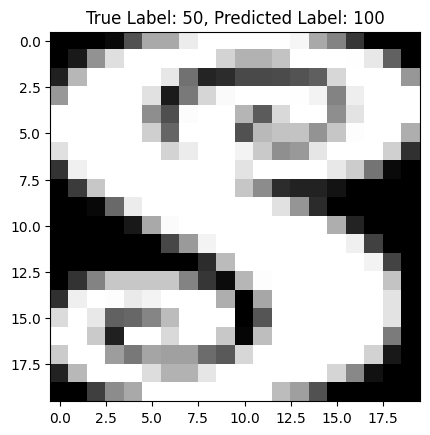

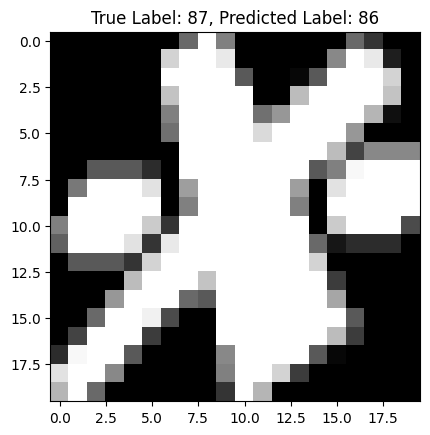

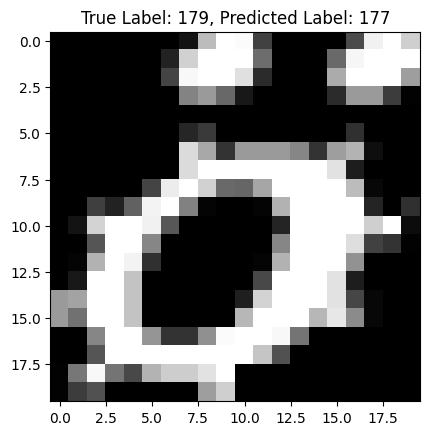

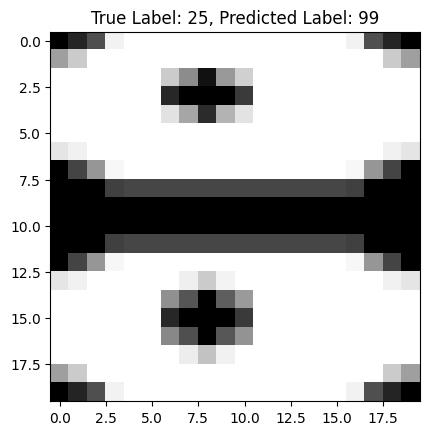

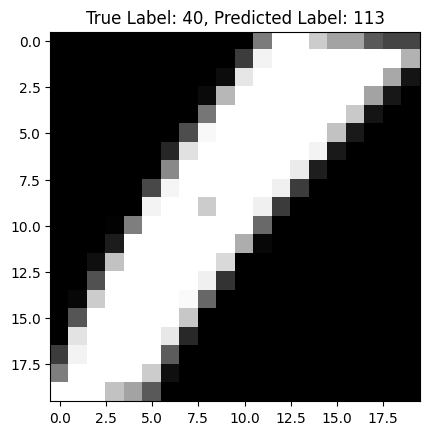

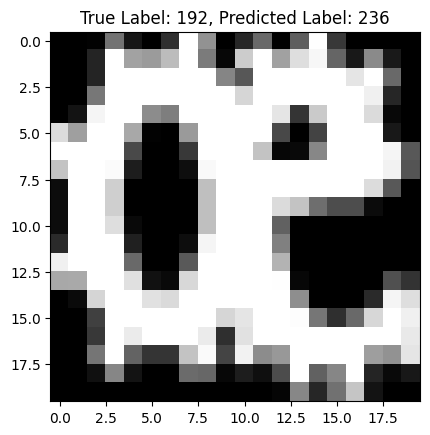

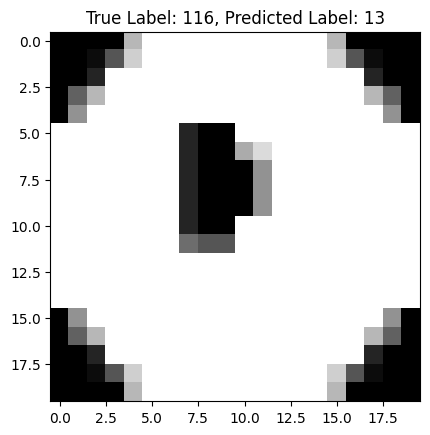

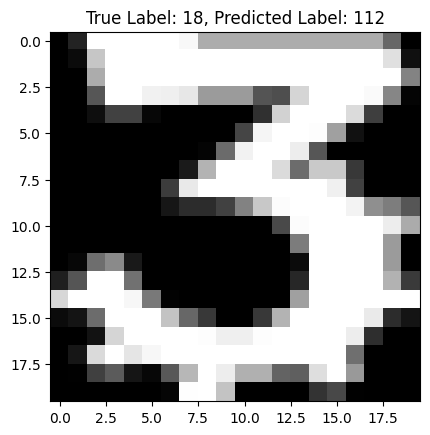

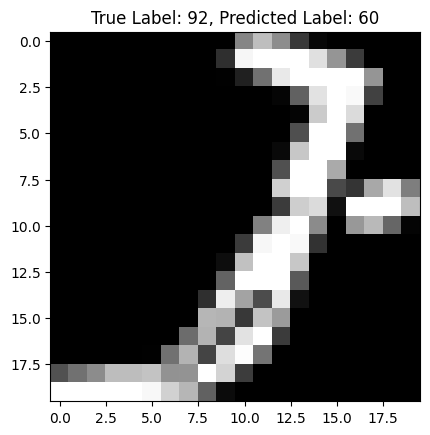

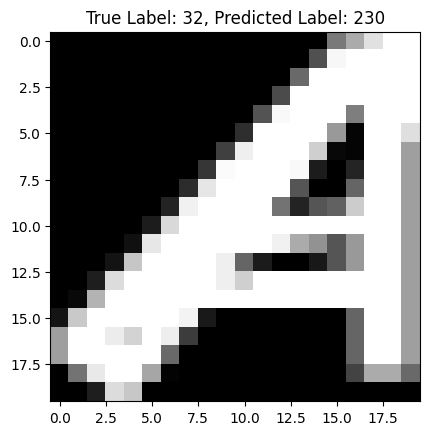

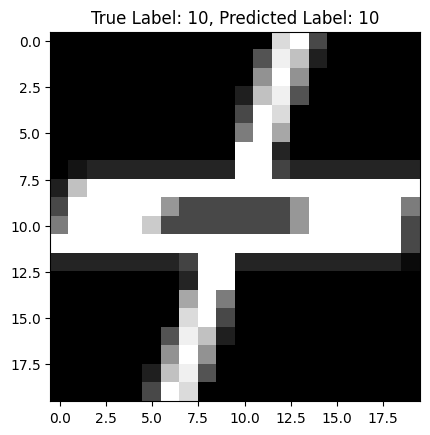

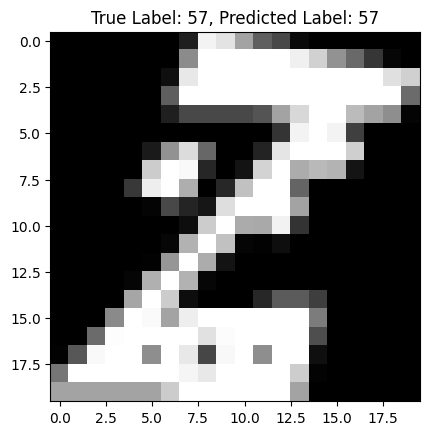

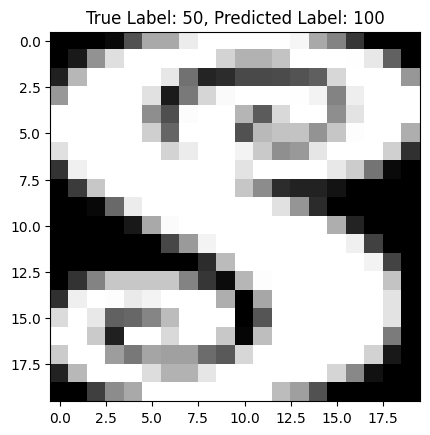

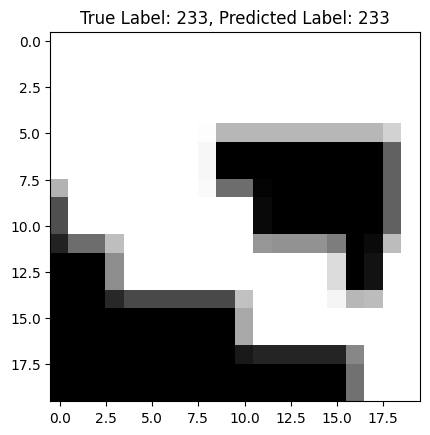

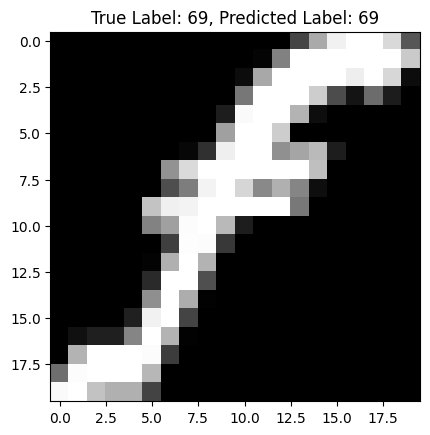

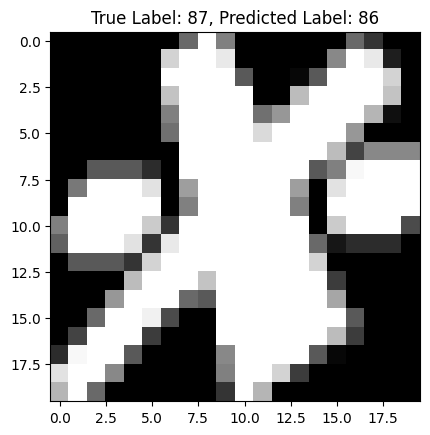

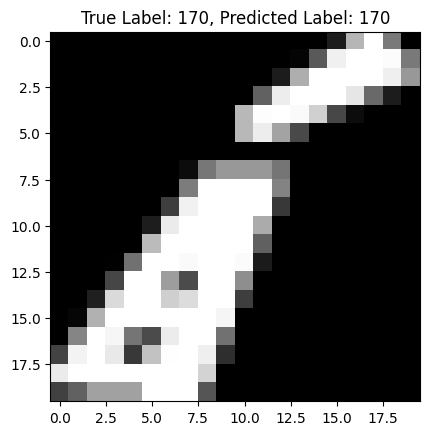

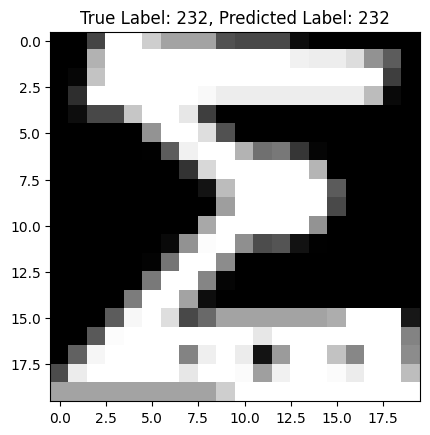

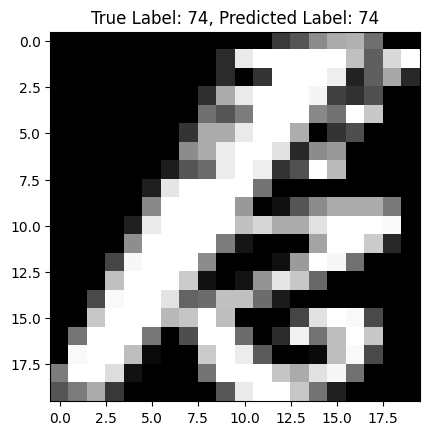

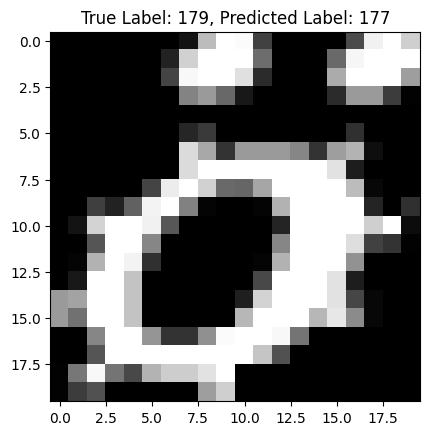

In [138]:
import torch
import matplotlib.pyplot as plt

def get_predictions(model, val_loader):
    model.eval()
    predictions = []
    true_labels = []
    probabilities = []
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            probabilities.extend(probs.cpu().numpy())
    
    return predictions, true_labels, probabilities

# look at misclassifed ones
def analyze_misclassifications(predictions, true_labels, probabilities, val_loader):
    misclassified_indices = [i for i, (pred, true) in enumerate(zip(predictions, true_labels)) if pred != true]
    
    # Print misclassified examples and their confidence scores
    for idx in misclassified_indices:
        print(f"Index: {idx}, True Label: {true_labels[idx]}, Predicted Label: {predictions[idx]}, Probabilities: {probabilities[idx]}")
    
    return misclassified_indices

#visualize it
def visualize_misclassifications(misclassified_indices, dataset):
    for idx in misclassified_indices[:10]:  # Visualize the first 10 misclassified examples
        image, label = dataset[idx]
        plt.imshow(image.squeeze(), cmap="gray")
        plt.title(f"True Label: {label}, Predicted Label: {predictions[idx]}")
        plt.show()

predictions, true_labels, probabilities = get_predictions(model, val_loader)
misclassified_indices = analyze_misclassifications(predictions, true_labels, probabilities, val_loader.dataset)
visualize_misclassifications(misclassified_indices, val_loader.dataset)

def find_unsure_predictions(probabilities, threshold=0.2):
    unsure_indices = [i for i, probs in enumerate(probabilities) if max(probs) < (1 - threshold)]
    return unsure_indices

unsure_indices = find_unsure_predictions(probabilities)
visualize_misclassifications(unsure_indices, val_loader.dataset)


<span style="color: pink;">

It look like the errors are happening a lot with symbols that have a slant. A lot of them have a diagonal line that goes from the bottom left corner to the top right corner. Maybe something about how we split the layers doesn't let us accurately find these lines and classify them? It has a hard time looking at the sybmol of "#" or "4". If i had more time I would've done analysis to see if the slant of these two symbols are differnet for different fonts. I wonder if one font has them more slanted than the other or if we could confuse our model more or less. 

</span>

## step 4: Denoising
Next we'll build and train a neural network (an autoencoder) for a different task: denoising images.

Next, create and train a convolutional autoencoder to denoise these images. The autoencoder network will probably be similar to the one we made in class, but then you train it, the inputs should be your noisy images (original image + some guassian (normal) noise added), and the expected outputs should be the "clean" images. It might be easiest to make a new NP array with the added noise.

Create a plot showing the noisy and denoised versions of some inputs to verify that your denoiser had the desired effect.

In [139]:
def add_noise(images, noise_factor=0.5):
    noisy_images = images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    noisy_images = np.clip(noisy_images, 0., 1.)
    return noisy_images

class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()
        # encode
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        # decode
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = DenoisingAutoencoder() # make new model
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [140]:
# add noise to old images
noisy_Xs = add_noise(Xs_tensor.numpy())
noisy_Xs_tensor = torch.tensor(noisy_Xs, dtype=torch.float32)

dataset = TensorDataset(noisy_Xs_tensor, Xs_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

def train_autoencoder(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}')

num_epochs = 10
train_autoencoder(model, train_loader, criterion, optimizer, num_epochs)


Epoch 1/10, Loss: 0.1885
Epoch 2/10, Loss: 0.1545
Epoch 3/10, Loss: 0.1078
Epoch 4/10, Loss: 0.0800
Epoch 5/10, Loss: 0.0690
Epoch 6/10, Loss: 0.0642
Epoch 7/10, Loss: 0.0610
Epoch 8/10, Loss: 0.0586
Epoch 9/10, Loss: 0.0566
Epoch 10/10, Loss: 0.0551


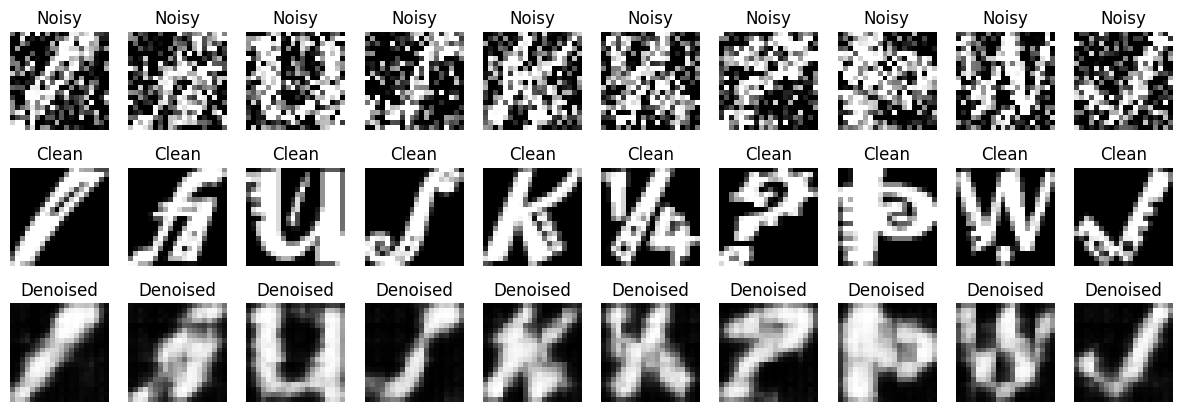

In [141]:
#display and visualization
def display_images(noisy_images, clean_images, denoised_images, num_images=10):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        # Noisy images
        plt.subplot(3, num_images, i + 1)
        plt.imshow(noisy_images[i].squeeze(), cmap='gray')
        plt.title('Noisy')
        plt.axis('off')
        
        # Clean images
        plt.subplot(3, num_images, num_images + i + 1)
        plt.imshow(clean_images[i].squeeze(), cmap='gray')
        plt.title('Clean')
        plt.axis('off')
        
        # Denoised images
        plt.subplot(3, num_images, 2 * num_images + i + 1)
        plt.imshow(denoised_images[i].squeeze(), cmap='gray')
        plt.title('Denoised')
        plt.axis('off')
    plt.show()

model.eval()
noisy_images, clean_images = next(iter(val_loader))
with torch.no_grad():
    denoised_images = model(noisy_images).cpu().numpy()

noisy_images = noisy_images.cpu().numpy()
clean_images = clean_images.cpu().numpy()

display_images(noisy_images, clean_images, denoised_images)
